# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# Импорт библиотек, классов и функций
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML

In [2]:
# Определяем константы (доступно только с Практикума)
RANDOM_STATE = 42
DATA_FILE = "/datasets/faces/labels.csv"
FILES_DIR = "/datasets/faces/final_files"

# Расширяем ноутбук для jupyter Практикума
display(HTML("<style>.container { width:90% !important; }</style>"))

### Загрузка данных

In [3]:
data = pd.read_csv(DATA_FILE)
data.info()
data.sample(5, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
800,000800.jpg,1
2644,002644.jpg,46
6521,006525.jpg,35
5572,005572.jpg,23
586,000586.jpg,47


Датасет содержит ссылки на 7'591 фотографий и целевой признак возраста, пропуски отсутствуют. Проверим наличие фотографий в файловой системе.

In [4]:
for i in tqdm(range(0, data.shape[0]), desc="Проверка файлов:"):
    data.loc[i, "is_file"] = os.path.isfile("/".join([FILES_DIR, data.loc[i, "file_name"]]))
print(f"Доступно {data['is_file'].sum()} файлов из {data.shape[0]}")

Проверка файлов::   0%|          | 0/7591 [00:00<?, ?it/s]

Доступно 7591 файлов из 7591


Пропущенные файлы отсутствуют, можно приступать к оценке данных.

### Оценка данных

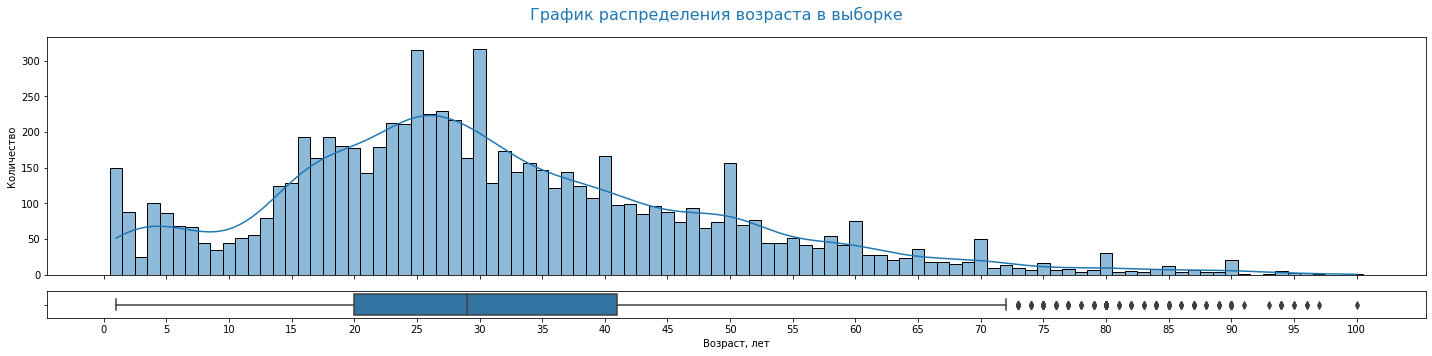

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max
Возраст,7591.0,31.201159,17.14506,1.0,1.0,1.0,20.0,29.0,41.0,82.0,94.0,100.0


In [5]:
fig, (ax_main, ax_box) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (.9, .1)}
)
fig.set_size_inches((20, 5))
sns.histplot(x=data["real_age"], kde=True, discrete=True, ax=ax_main).set(ylabel="Количество")
sns.boxplot(x=data["real_age"], ax=ax_box)
plt.suptitle("График распределения возраста в выборке", size=16, color="C0")
plt.xlabel("Возраст, лет")
ax_box.set_xticks(range(0, 105, 5))
plt.tight_layout()
plt.show()
data["real_age"].rename("Возраст").describe(
    percentiles=[0.0013, 0.01, .25, .5, .75, .99, .9987]
).to_frame().T

Половину выборки составляют фотографии людей возврастом от 20 до 41 года, медиана - 29 лет. В целом выборка содержит фотографии людей от 1-го года до 100 лет. Довольно большое количество детей в возрасте менее 10 лет, в том числе дети возрастом 1 год. Довольно часто встречаются круглые даты, два наиболее часто встречающихся значения приходятся на 30 и 25 лет, также заметны выделяющиеся относительно ближайших значения - 40, 50, 60, 70, 80 и 90 лет.

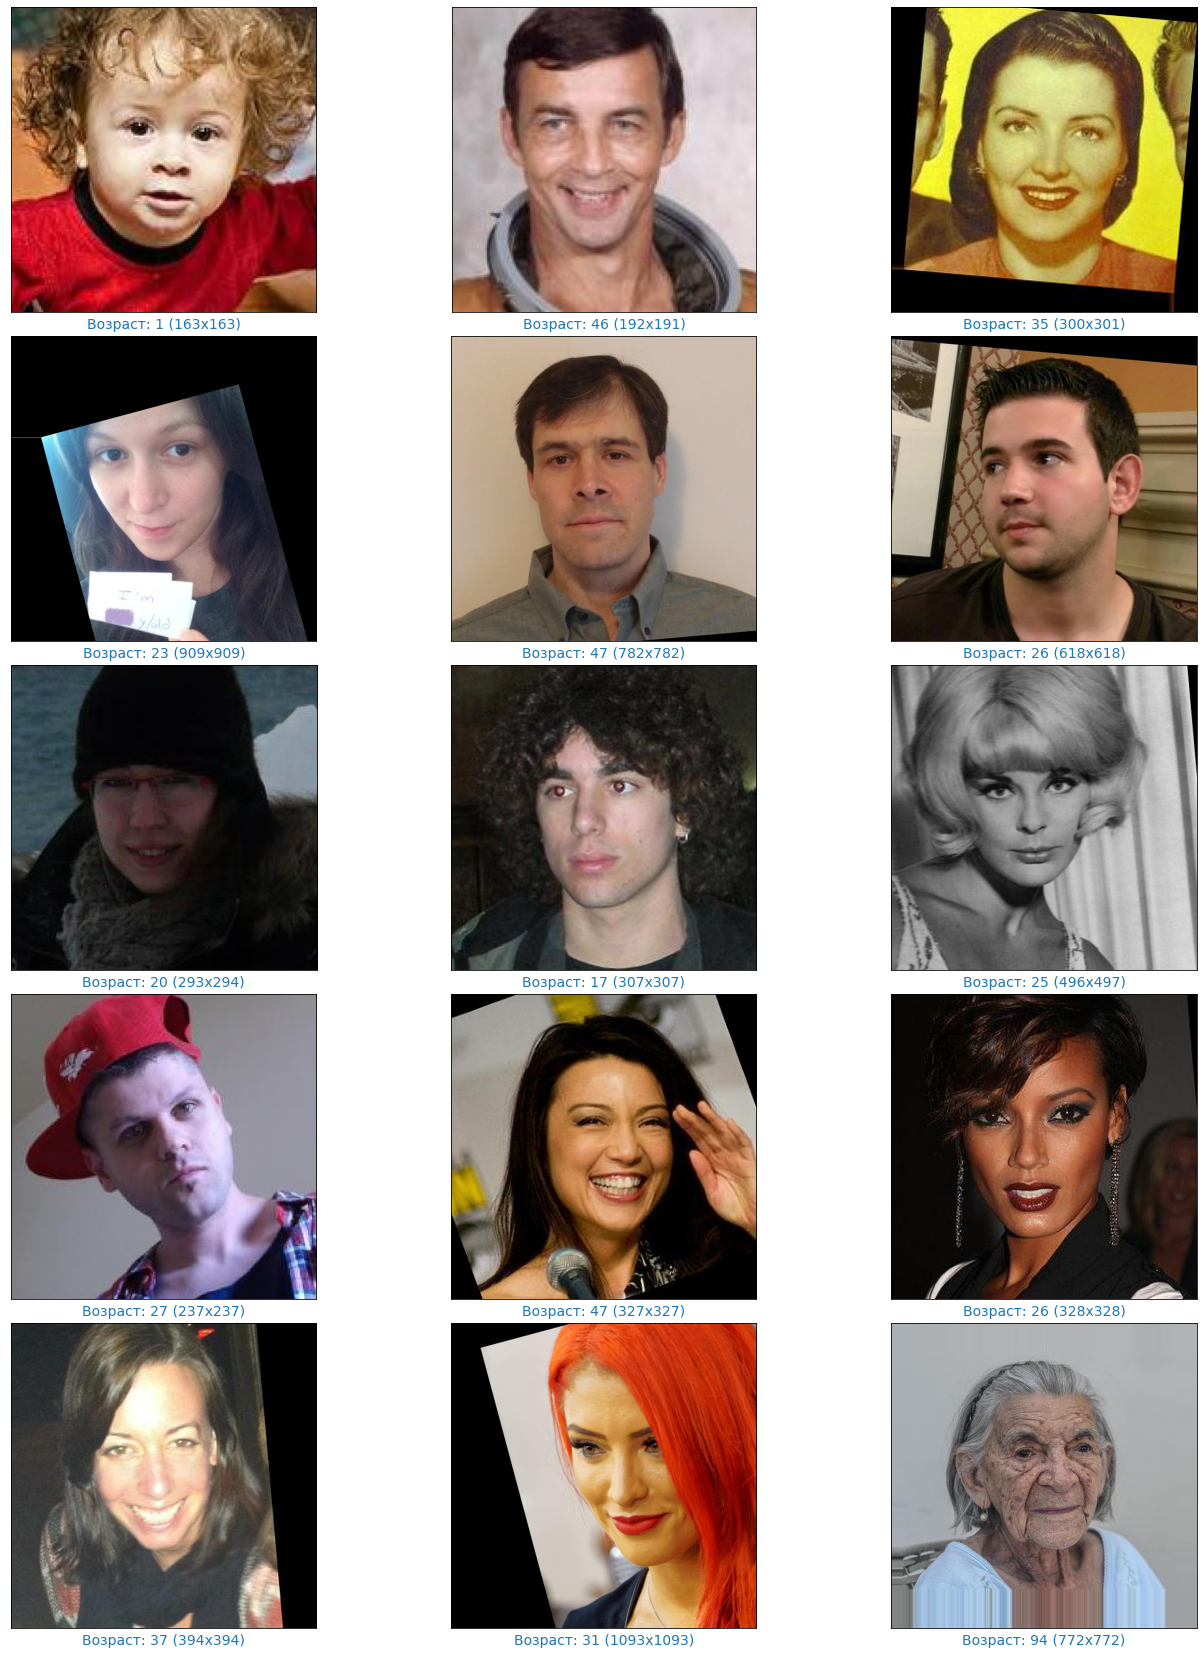

In [6]:
fig = plt.figure(figsize=(20, 23))
ax = fig.subplots(5, 3)
for idx, row in data.sample(15, random_state=RANDOM_STATE).reset_index(drop=True).iterrows():
    img = np.array(Image.open("/".join([FILES_DIR, row["file_name"]])))
    ax[idx // 3, idx % 3].imshow(img)   
    ax[idx // 3, idx % 3].get_xaxis().set_visible(False)
    ax[idx // 3, idx % 3].get_yaxis().set_visible(False)
    ax[idx // 3, idx % 3].set_title(
        f"Возраст: {row['real_age']} ({img.shape[0]}x{img.shape[1]})", 
        y=-.075, size=14, color="C0")
plt.tight_layout()
plt.show()

Можно отметить, что изображения имеют различное разрешение. Оценим какой разброс разрешений у изображений в предоставленном датасете.

In [7]:
# чтение данных по изображению
for i in tqdm(range(0, data.shape[0]), desc="Чтение файлов"):
    img = np.array(Image.open("/".join([FILES_DIR, data.loc[i, "file_name"]])))
    data.loc[i, ["height", "width", "chanels"]] = img.shape

Чтение файлов:   0%|          | 0/7591 [00:00<?, ?it/s]

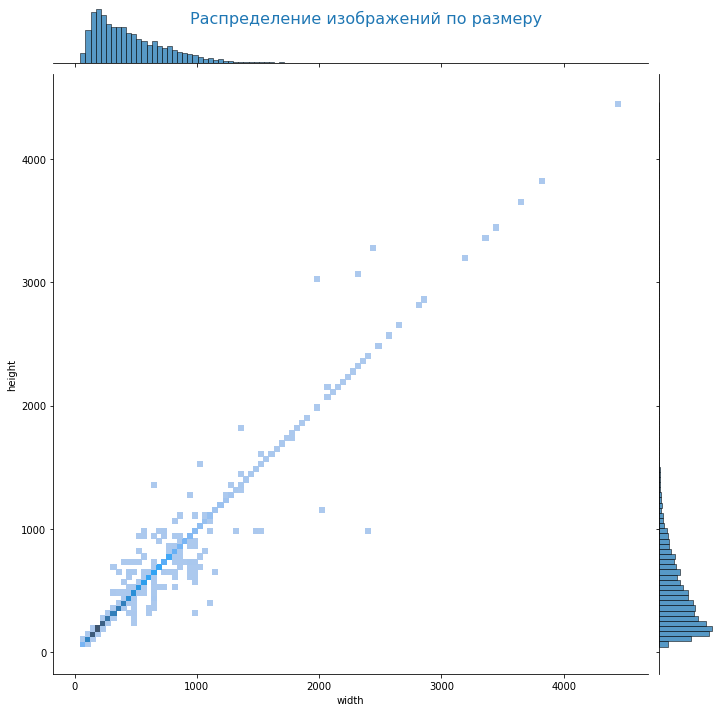

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
height,7591.0,464.093927,331.289883,47.0,82.0,117.0,220.0,384.0,632.0,1035.0,1475.1,4466.0
width,7591.0,464.733764,330.834794,47.0,82.0,117.0,220.0,385.0,632.0,1035.0,1500.0,4466.0
chanels,7591.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [8]:
g = sns.JointGrid(data=data, x="width", y="height", height=10, ratio=9)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.histplot)
plt.suptitle("Распределение изображений по размеру", size=16, color="C0")
plt.show()
data[["height", "width", "chanels"]].describe(
    percentiles=[0.01, 0.05, .25, .5, .75, .95, .99]
).T

Можно отметить достаточно большое количество очень маленьких по размеру изображений - не менее 5% датасета, это изображения размерностью менее 120 пикселей. При этом все изображения содержат 3 канала, вероятно это цветные RGB фотографии. Основная масса изображений близки к квадратным с соотношением стороным, близким к 1х1. Однако встречаются фотографии с более сильным расхождением в отношениях сторон, взглянем на такие фото.

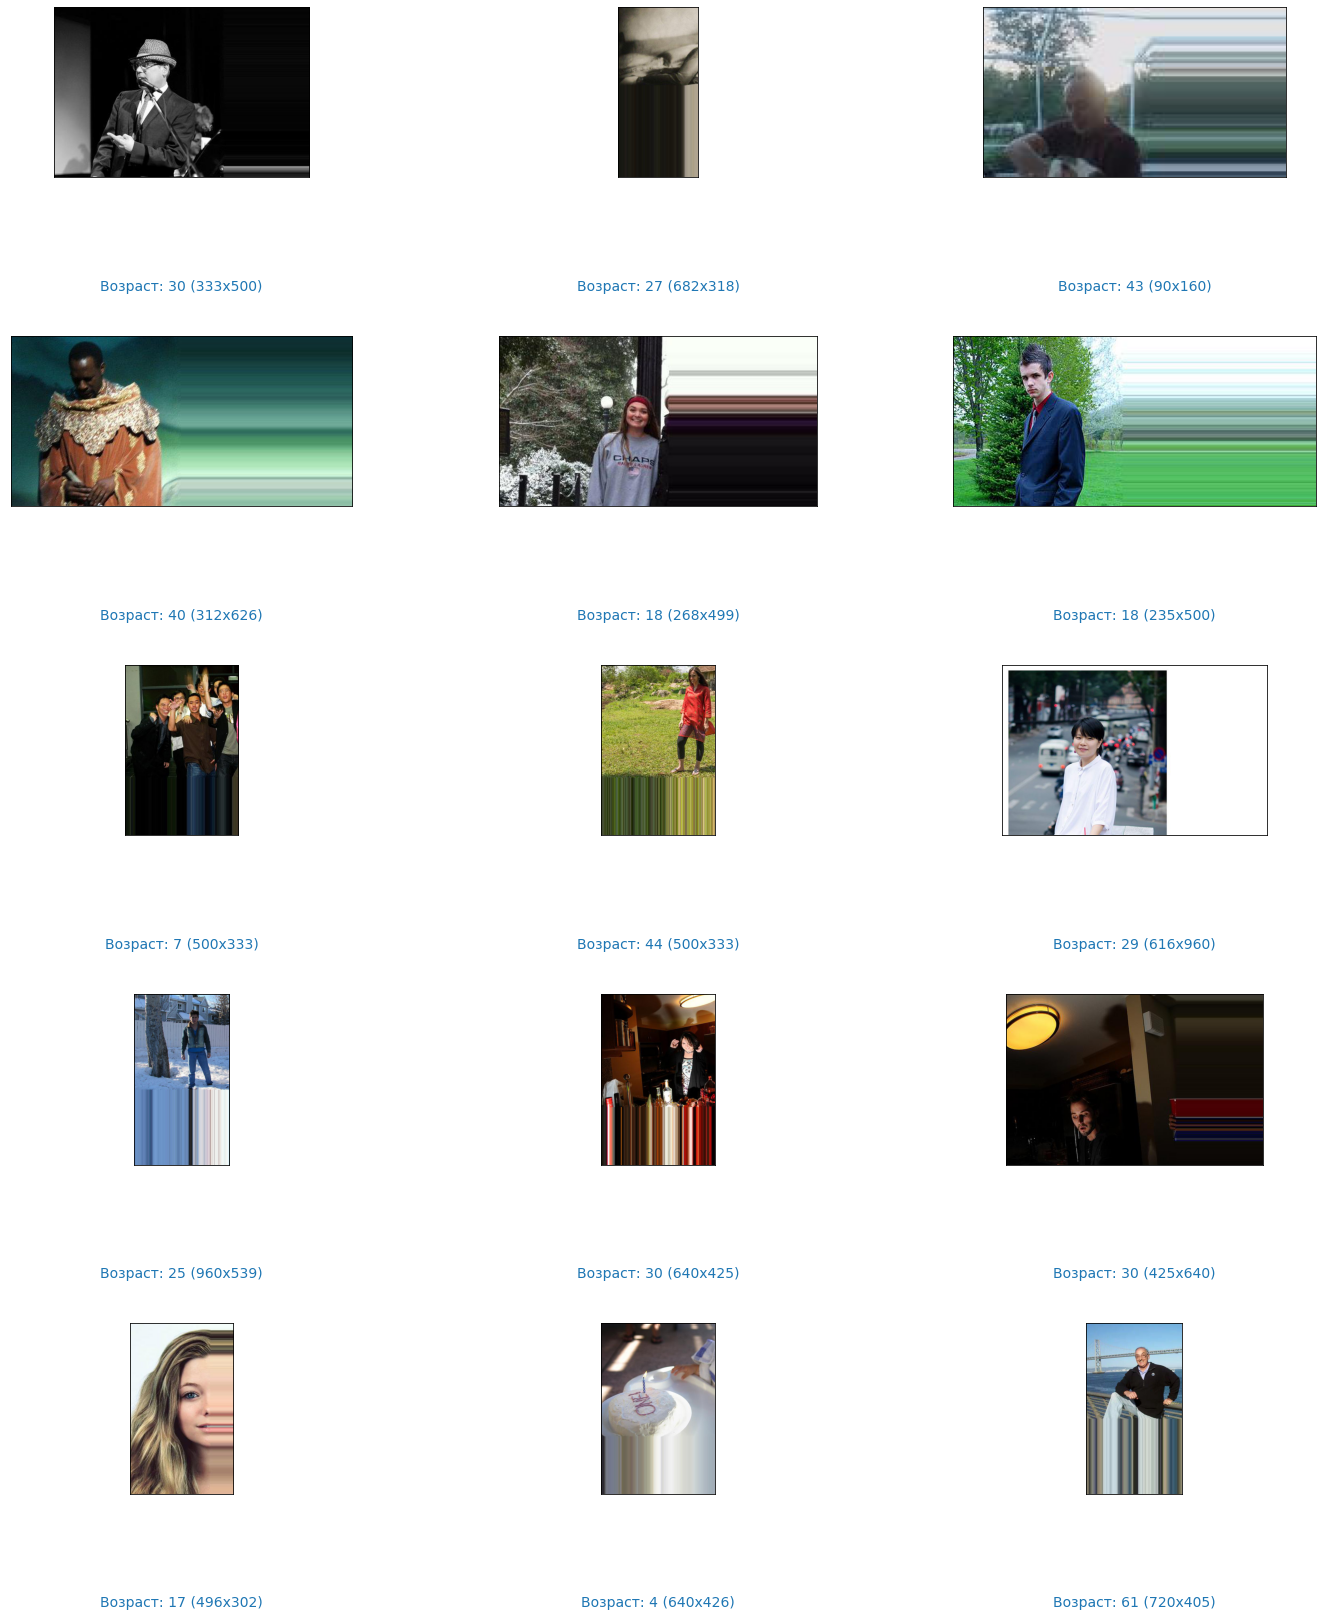

In [9]:
fig = plt.figure(figsize=(20, 23))
ax = fig.subplots(5, 3)
for idx, row in data[
    (data["width"] > data["height"]*1.5) | 
    (data["height"] > data["width"]*1.5)
].sample(15, random_state=RANDOM_STATE).reset_index(drop=True).iterrows():
    img = np.array(Image.open("/".join([FILES_DIR, row["file_name"]])))
    ax[idx // 3, idx % 3].imshow(img)   
    ax[idx // 3, idx % 3].get_xaxis().set_visible(False)
    ax[idx // 3, idx % 3].get_yaxis().set_visible(False)
    ax[idx // 3, idx % 3].set_title(
        f"Возраст: {row['real_age']} ({img.shape[0]}x{img.shape[1]})", 
        y=-.7, size=14, color="C0")
plt.tight_layout()
plt.show()

По изображениям, соотношение сторон которых сильно отличается от 1х1 можно отметить, что в основном встречаются изображения, которые по какой-то причине были сильно растянуты в одну из сторон - либо вниз, либо вправо. Причину такого искажения назвать затрудняюсь, так как большого смысла в этом не вижу. Наиболее оптимальным будет обрезка фотографии по наименьшей из сторон по левому верхнему углу, чтобы не приводить к сильным искажениям при преобразовании изображений к единому размеру. Даже в кейсе с вертикальной фотографией половины лица девушки, растянутой по горизонтали это будет лучше, чем искажение размера.

Дополнительно стоит отметить, что в используемом датасете встречаются изображения, на которых присутствует более одного человека, а также изображения далеко расположенных людей, либо отсутвие лица на изображениях. Это не позволит модели добиться очень высоких результатов. Желательно провести очистку датасета от таких изображений.

### Промежуточные выводы

По полученному датасету можно сделать следующие выводы:
1. ChaLearn LAP включает большое разнообразие фотографий с людьми разного возраста, пола и этнической принадлежности. Это важный аспект для задачи машинного обучения, связанной с определением возраста в условиях магазина, поскольку покупатели также могут представлять широкий спектр возрастов и внешних характеристик.
2. В части аугментации данных, фотографии сделаны в разных условиях освещённости, ракурсов и качества съемки, что приближает их к реальным условиям в магазине, когда может присутствовать как естественное освещение, так и искуственное. Дополнительно можно отметить, что в датасете присуствует частично перекрытые головными уборами или прической лица, так как в реальных магазинах покупатели могут двигаться, частично закрывать лицо масками, шляпами и т.д.
3. Фото имеют довольно большой разброс по размеру, при этом имеются расхождения по соотношению сторон, для некоторых изображений довольно сильные. Необходимо приводить к единому размеру, а также обеспечить обрезку фото для обучения нейросети.

Дополнительно можно отметить, что применение техники Transfer Learning с предобученной моделью на датасете ImageNet не будет оптимальным, так как задачи довольно сильно отличаются. Наилучшим решением было бы использовать предобученную на распознавании лиц модель, такую как VGGFace2. В данном проекте будет использован ResNet50 без предобученных весов для тренировки всей нейросети на имеющемся датасете. Для улучшения резуьтатов будет использована аугментация данных, так как датасет небольшой.

В качестве метрики для оценки моделей определена Mean Absolute Error (MAE) - средняя абсолютная ошибка, представляющая разницу между предсказаниями и фактическими данными. В целях поиска наиболее подходящей модели будет использоваться метрика Mean Squared Error (MSE) - среднеквадратическая ошибка, которая позволит сократить более сильные расхождения между предсказаниями и фактическими данными.

## Обучение модели

<div class="alert alert-info">
<font size="3"><b>Комментарий</b></font>
    
Дальнейший код выполнялся на GPU-тренажере Практикума, после которого представлен вывод запуска модели.
</div>

### Код обучения модели:

```python

import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

DATA_FILE = "labels.csv"
FILES_DIR = "final_files"
RESCALE = 1/255
TARGET_SIZE = (224, 224)
VAL_SIZE = 0.25
BATCH_SIZE = 32
RANDOM_STATE = 42

def crop_image(img):
    img_shape = tf.shape(img)
    min_side = min(img_shape[0], img_shape[1])
    crpd_img = tf.image.crop_to_bounding_box(
        img, 0, 0, min_side, min_side
    )
    return tf.image.resize(crpd_img, TARGET_SIZE)

def load_train(path):
    datafile = path + DATA_FILE
    if os.path.isfile(datafile):
        df = pd.read_csv(datafile)
        tr_dg = ImageDataGenerator(
            rescale=RESCALE, validation_split=VAL_SIZE,
            preprocessing_function=crop_image,
            horizontal_flip=True, rotation_range=45, 
            width_shift_range=0.2, height_shift_range=0.2,
            zoom_range=0.2, 
            fill_mode='nearest'
        )
        files = path + FILES_DIR
        if os.path.exists(files):
            tr_dg_flow = tr_dg.flow_from_dataframe(
                dataframe=df, directory=files,
                x_col="file_name", y_col="real_age",
                target_size=TARGET_SIZE, 
                batch_size=BATCH_SIZE,
                class_mode='raw', subset='training',
                seed=RANDOM_STATE
            )
            return tr_dg_flow
        else:
            print(f"Папка '{files}' не найдена")
    else:
        print(f"Файл '{datafile}' не найден")
    return None

def load_test(path):
    datafile = path + DATA_FILE
    if os.path.isfile(datafile):
        df = pd.read_csv(datafile)
        val_dg = ImageDataGenerator(
            rescale=RESCALE, validation_split=VAL_SIZE,
            preprocessing_function=crop_image
        )
        files = path + FILES_DIR
        if os.path.exists(files):
            val_dg_flow = val_dg.flow_from_dataframe(
                dataframe=df, directory=files,
                x_col="file_name", y_col="real_age",
                target_size=TARGET_SIZE, 
                batch_size=BATCH_SIZE,
                class_mode='raw', subset='validation',
                seed=RANDOM_STATE
            )
            return val_dg_flow
        else:
            print(f"Папка '{files}' не найдена")
    else:
        print(f"Файл '{datafile}' не найден")
    return None

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        # Оставил предварительно загруженные веса, чтобы ускорить процесс
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False # Исключение последних слоев
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu")) # Нейрон для задачи регрессии 
    model.compile(
        optimizer=Adam(0.0001), # Установка learning rate для снижения скорости обучения 
        loss="mean_squared_error", # Функция потерь для обучения MSE позволит быстрее обучиться
        metrics=["mae"]) # Метрика для предсказаний MAE
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=100,
               steps_per_epoch=None, validation_steps=None):
    # Добавление остановки в случае отсутствия прогресса по метрике
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Снижение learning rate при достижении плато на обучении
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True, 
              callbacks=[early_stopping, reduce_lr]
    )
    return model

```

### Вывод запуска модели:

```

2024-10-04 14:07:25.679926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-10-04 14:07:25.682396: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-10-04 14:07:26.831355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-04 14:07:26.838542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-10-04 14:07:26.838609: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-04 14:07:26.838650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-04 14:07:26.840795: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-10-04 14:07:26.841203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-10-04 14:07:26.843503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-10-04 14:07:26.844885: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-10-04 14:07:26.844948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-10-04 14:07:26.847913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-10-04 14:07:27.062166: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-10-04 14:07:27.070120: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2024-10-04 14:07:27.070931: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x498dfb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-10-04 14:07:27.070959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-10-04 14:07:27.221868: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ca3ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-04 14:07:27.221914: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-10-04 14:07:27.223745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-10-04 14:07:27.223818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-04 14:07:27.223845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-04 14:07:27.223888: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-10-04 14:07:27.223921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-10-04 14:07:27.223952: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-10-04 14:07:27.223982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-10-04 14:07:27.224003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-10-04 14:07:27.227187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-10-04 14:07:27.227265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-10-04 14:07:27.664713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-10-04 14:07:27.664772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-10-04 14:07:27.664787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-10-04 14:07:27.668083: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-04 14:07:27.668170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/100
2024-10-04 14:07:42.646729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-04 14:07:43.595074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 178s - loss: 297.6241 - mae: 12.4690 - val_loss: 1028.5633 - val_mae: 27.2890
Epoch 2/100
178/178 - 166s - loss: 121.6890 - mae: 8.2950 - val_loss: 892.9412 - val_mae: 24.8806
Epoch 3/100
178/178 - 165s - loss: 102.4966 - mae: 7.6676 - val_loss: 282.8978 - val_mae: 12.3409
Epoch 4/100
178/178 - 166s - loss: 88.8251 - mae: 7.0868 - val_loss: 143.0378 - val_mae: 8.5387
Epoch 5/100
178/178 - 176s - loss: 78.1057 - mae: 6.7380 - val_loss: 104.0523 - val_mae: 7.8348
Epoch 6/100
178/178 - 180s - loss: 72.7231 - mae: 6.5157 - val_loss: 95.9200 - val_mae: 7.3630
Epoch 7/100
178/178 - 182s - loss: 66.8150 - mae: 6.2342 - val_loss: 104.3379 - val_mae: 7.6547
Epoch 8/100
178/178 - 181s - loss: 62.2574 - mae: 5.9930 - val_loss: 80.7909 - val_mae: 6.8335
Epoch 9/100
178/178 - 182s - loss: 51.5996 - mae: 5.5215 - val_loss: 86.4510 - val_mae: 6.8647
Epoch 10/100
178/178 - 183s - loss: 55.8612 - mae: 5.7288 - val_loss: 74.5624 - val_mae: 6.4630
Epoch 11/100
178/178 - 167s - loss: 49.6043 - mae: 5.3883 - val_loss: 71.7662 - val_mae: 6.3552
Epoch 12/100
178/178 - 169s - loss: 45.7894 - mae: 5.1608 - val_loss: 107.9297 - val_mae: 8.0866
Epoch 13/100
178/178 - 170s - loss: 42.0160 - mae: 4.9797 - val_loss: 77.2835 - val_mae: 6.5910
Epoch 14/100

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
178/178 - 214s - loss: 40.3185 - mae: 4.8610 - val_loss: 75.6381 - val_mae: 6.4720
Epoch 15/100
178/178 - 215s - loss: 30.7300 - mae: 4.2649 - val_loss: 63.2291 - val_mae: 5.8548
Epoch 16/100
178/178 - 195s - loss: 27.7291 - mae: 4.0387 - val_loss: 62.8920 - val_mae: 5.8146
Epoch 17/100
178/178 - 172s - loss: 25.7027 - mae: 3.9117 - val_loss: 65.1017 - val_mae: 5.9677
Epoch 18/100
178/178 - 201s - loss: 25.0622 - mae: 3.8783 - val_loss: 61.7235 - val_mae: 5.7589
Epoch 19/100
178/178 - 211s - loss: 23.1513 - mae: 3.7271 - val_loss: 62.0226 - val_mae: 5.7591
Epoch 20/100
178/178 - 207s - loss: 22.1779 - mae: 3.6405 - val_loss: 62.4623 - val_mae: 5.8534
Epoch 21/100
178/178 - 177s - loss: 20.9101 - mae: 3.5510 - val_loss: 61.0056 - val_mae: 5.7353
Epoch 22/100
178/178 - 169s - loss: 21.1463 - mae: 3.5546 - val_loss: 61.7548 - val_mae: 5.8083
Epoch 23/100
178/178 - 171s - loss: 20.4928 - mae: 3.4813 - val_loss: 61.1774 - val_mae: 5.7226
Epoch 24/100

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1e-06.
178/178 - 170s - loss: 20.3978 - mae: 3.4798 - val_loss: 61.3706 - val_mae: 5.7515
Epoch 25/100
178/178 - 167s - loss: 18.6468 - mae: 3.3276 - val_loss: 60.8382 - val_mae: 5.7304
Epoch 26/100
178/178 - 156s - loss: 18.5662 - mae: 3.3479 - val_loss: 60.8341 - val_mae: 5.7276
Epoch 27/100
178/178 - 156s - loss: 18.5032 - mae: 3.3229 - val_loss: 60.6408 - val_mae: 5.7351
Epoch 28/100
178/178 - 156s - loss: 18.6906 - mae: 3.3353 - val_loss: 60.8253 - val_mae: 5.7383
Epoch 29/100
178/178 - 158s - loss: 18.0097 - mae: 3.2693 - val_loss: 60.7197 - val_mae: 5.7331
Epoch 30/100
178/178 - 162s - loss: 18.3577 - mae: 3.3132 - val_loss: 60.8725 - val_mae: 5.7489
Epoch 31/100
Epoch 32/100
178/178 - 163s - loss: 18.2982 - mae: 3.2947 - val_loss: 61.0353 - val_mae: 5.7541
178/178 - 166s - loss: 17.7792 - mae: 3.2701 - val_loss: 60.8278 - val_mae: 5.7463
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 20s - loss: 60.6408 - mae: 5.7351
Test MAE: 5.7351



```

## Анализ обученной модели

В рамках настоящего проекта произведено изучение данных, в рамках которой выявлено следующее:
1. Датасет имеет довольно разнообразные фото людей различного возраста, пола и этнической принадлежности, что достаточно хорошо для обобщающих свойств модели.
2. Фото из датасета сделаны при различной освещенности, что соответственно приближает данный датасет к реальной задаче, где может быть как естетственное освещение, так и искуственное. Также имеются черно-белые фото, что вероятно снизит влияние освещенности.
3. Фото имеют довольно большой разброс как по размеру, так и по соотношению сторон. В части соотношения сторон было выявлено наличие значительно большей ширины, либо высоты фото - в основном исходное фото в левой верхней части изображения, которое растянуто на базе ближайших пикселей, либо просто расширением с добавлением одного цвета. Причины такого изменения не получилось определить, но для более точных предсказаний было решено осуществлять обрезку фото по наименьшему размеру сохраняя верхний левый угол.
4. Имеются изображения, на которых люди находятся достаточно далеко, вследствие чего качество изображения лица может быть очень низким, также имеются фото, на которых присутствуют несколько человек. Данный факт не позволит достаточно хорошо обучить модель, которая будет показывать очень высокую метрику на используемых данных.
5. Имеется довольно большое количество данных, целевое значение которых близко к "круглым" датам, что либо наталкивает на мысль, что это не точные а близкие значения, либо фотографии приходились на такие "круглые" даты.
6. Имеется довольно малое количество данных для обучения - всего 7 591 фото.

Для обучения модели определны следующие параметры:
1. Выбрана модель ResNet50 без предобучения, так как в keras без подключения дополнительных модулей отсутствуют предобученные на распознавании лиц моделей. Был использован сохраненный датасет ImageNet только для снижения нагрузки на сеть при копировании первичных весов модели, возможно это также ускорит обучение новой модели.
2. В качестве основной метрики определена метрика MAE (Mean Absolute Error), а в целях обучения использована функция потерь MSE (Mean Squared Error), которая обеспечит снижение больших выбросов предсказанных значений.
3. В целях улучшения процесса обучения используется аугментация данных, в том числе сдвиги до 20%, повороты до 45 градусов, а также отражение по горизонтали.
4. Результаты обучения предсказываются одним нейроном с функцией активации ReLU в целях обрезки предсказаний ниже 0 значения.
5. В качестве функции оптимизации выбран алгорит Adam со значением learning rate равным 0,0001. При обучении применены процедуры ранней остановки и снижения learning rate в случае выхода на плато по обучению.

Дополнительным улучшением было бы использование моделей для детекции человека на фотографии для передачи только изображения человека (верхней его части), чтобы нейросеть не обучалась на лишних данных.

Подготовлены функции для подготовки датасета, модели и ее обучения. Для выгрузки датасета используется функция `flow_from_dataframe` класса `ImageDataGenerator` из библиотеки `Keras` с разделением тренировочной и валидационной выборки в соотношении 3/1. Выборка разделена на 5694 фото для тренировочных данных и 1897 фото для валидации, размер батча 32 изображения, что предполагает 178 шагов для обучения и 60 шагов для валидации. По факту обучения сверточной нейросети на датасете можно отметить следующее:
- после первой эпохи обучения значение MAE для тренировочной выборки получило значение 12,5 и для валидационной выборки составило 27,3;
- довольно большое улучшение произошло на 4-й эпохе, когда значение MAE для валидационной выборки снизилось с 12,3 до 8,5 лет и значение функции потерь снизилось достаточно сильно;
- далее идет улучшение по тренировочной выборке, однако на тестовой выборке достаточно сильно приостановилось на 12-14 эпохах, там же проиходит уменьшение learning rate;
- наилучшее значение для MAE получилось на 23 эпохе со значением 5,72. Дальше были только снижения по квадратичной ошибке;
- по функции потерь наилучшее значение было достигнуто на 27 эпохе, после чего, вероятно, происходит переобучение или даже остановка в обучении.